In [1]:
# !pip install git+https://github.com/crispitagorico/sigkernel.git
# !git clone 'https://github.com/ryanmccrickerd/rough_bergomi.git'

In [1]:
import numpy as np
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from rbergomi import rBergomi, rBergomi_MC_pricer, rBergomi_sigkernel_pricer
from utils import r2, mse, generate_evaluation_paths, plot_results
# from sklearn.metrics import r2_score as r2

import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
T, a, xi, eta, rho = 1., -.4, .055, 1.9, -.9
n_increments       = 10
log_strike         = -5.  
payoff_eur_call    = lambda x: max(np.exp(x) - np.exp(log_strike), 0.) 
x_var              = 1.

In [10]:
n_eval       = 50
t_inds_eval  = np.random.choice(n_increments, n_eval)
xs_eval      = np.array([np.random.normal(loc=-xi*t/2, scale=x_var, size=1) for t in t_inds_eval])
paths_eval   = generate_evaluation_paths(t_inds_eval, n_increments, T, a)

In [11]:
# for path in paths_eval:
#     plt.plot(path[:,0], path[:,1])
# plt.show()

In [12]:
n_samples_MC = 30000
mc_pricer = rBergomi_MC_pricer(n_increments, n_samples_MC, T, a, xi, eta, rho)

In [13]:
%%time
mc_prices = mc_pricer.fit_predict(t_inds_eval, xs_eval, paths_eval, payoff_eur_call)

CPU times: user 9.29 s, sys: 259 ms, total: 9.55 s
Wall time: 9.55 s


In [14]:
mc_prices

array([0.53405697, 4.53056916, 0.38288242, 1.53666611, 0.42797827,
       2.51107332, 2.45241849, 0.64681745, 3.96122673, 1.58335229,
       0.92180461, 0.99769393, 3.29807847, 1.71330395, 0.91195631,
       0.56908747, 0.80949292, 7.84314859, 0.2702177 , 0.36270852,
       2.17430095, 0.43793712, 0.64847039, 1.09465797, 0.49755661,
       2.9154213 , 0.50228989, 0.38642861, 1.20199928, 0.47435029,
       0.62522244, 0.61133948, 0.46788923, 5.84316069, 0.15028899,
       0.15329093, 0.1534543 , 0.58668987, 3.02600746, 0.43162179,
       0.96688132, 1.20947231, 2.30750655, 1.21706073, 0.76541718,
       0.5899646 , 4.8132502 , 1.03959699, 1.21886424, 0.53722204])

In [15]:
m = 200   # collocation points interior
n = 200   # collocation points boundary

max_batch    = 100 
dyadic_order = 1 

sigma_sig:   0%|          | 0/3 [00:00<?, ?it/s]

sigma_t:   0%|          | 0/3 [00:00<?, ?it/s]

sigma_x:   0%|          | 0/3 [00:00<?, ?it/s]

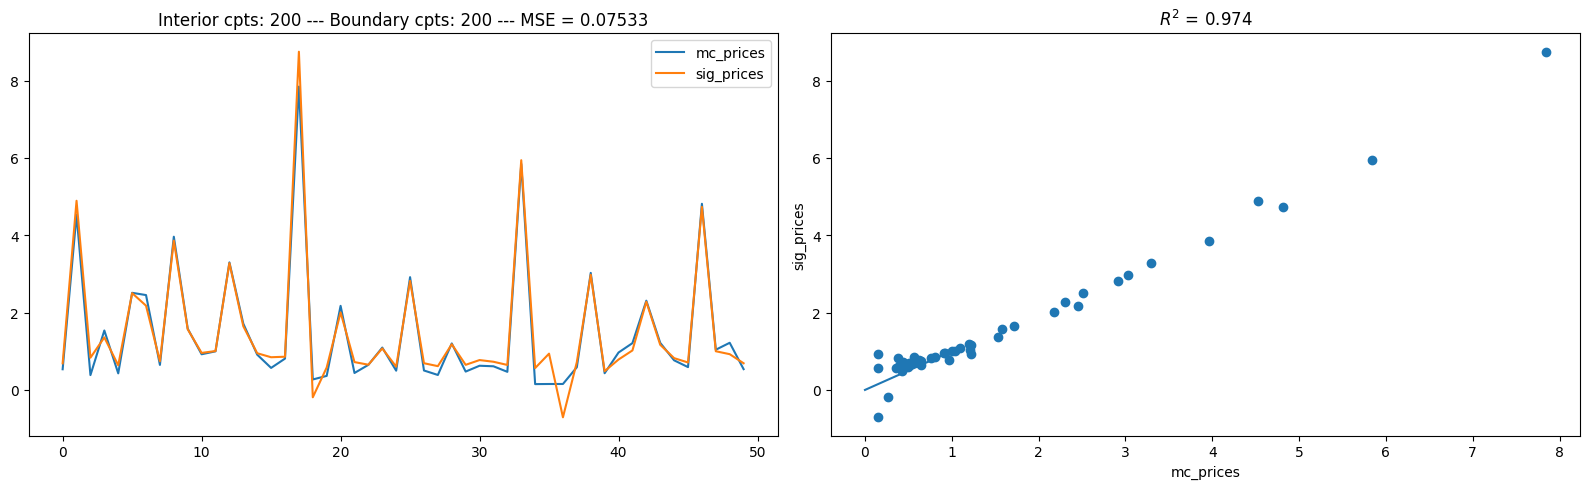

0.5 0.5 10.0


sigma_x:   0%|          | 0/3 [00:00<?, ?it/s]

sigma_x:   0%|          | 0/3 [00:00<?, ?it/s]

sigma_t:   0%|          | 0/3 [00:00<?, ?it/s]

sigma_x:   0%|          | 0/3 [00:00<?, ?it/s]

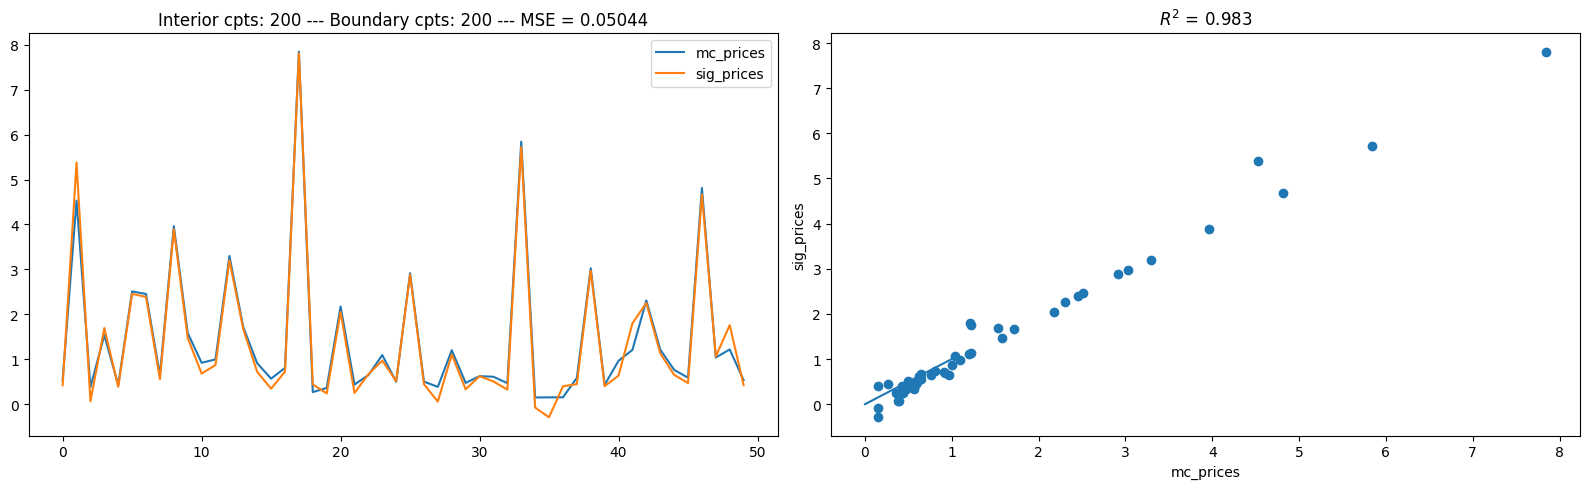

0.5 0.5 50.0


sigma_x:   0%|          | 0/3 [00:00<?, ?it/s]

sigma_x:   0%|          | 0/3 [00:00<?, ?it/s]

sigma_t:   0%|          | 0/3 [00:00<?, ?it/s]

sigma_x:   0%|          | 0/3 [00:00<?, ?it/s]

sigma_x:   0%|          | 0/3 [00:00<?, ?it/s]

sigma_x:   0%|          | 0/3 [00:00<?, ?it/s]

In [16]:
mse_score = 1e9
r2_score = 0
for sigma_sig_ in tqdm([1e1, 5e1, 1e2], desc="sigma_sig", position=0):
    for sigma_t_ in tqdm([5e-1, 1e-1, 5e-2], desc="sigma_t", position=1, leave=False):
        for sigma_x_ in tqdm([5e-1, 1e-1, 5e-2], desc="sigma_x", position=2, leave=False):
            
            sig_pricer = rBergomi_sigkernel_pricer(n_increments, x_var, m, n, T, a, xi, eta, rho, 
                                                   sigma_t_, sigma_x_, sigma_sig_, dyadic_order, max_batch, device)
            
            sig_pricer.fit(payoff_eur_call)
            
            sig_prices = sig_pricer.predict(t_inds_eval, xs_eval, paths_eval) 
            
            mse_score_ = mse(mc_prices, sig_prices)
            r2_score_  = r2(mc_prices, sig_prices)
            
            if mse_score_ < mse_score: #and r2_score_ > r2_score:
                
                plot_results(mc_prices, sig_prices, m, n)
                
                sigma_t   = sigma_t_
                sigma_x   = sigma_x_
                sigma_sig = sigma_sig_   
                mse_score = mse_score_
                r2_score  = r2_score_
                
                print(sigma_t, sigma_x, sigma_sig)

In [17]:
sig_pricer = rBergomi_sigkernel_pricer(n_increments, x_var, m, n, T, a, xi, eta, rho, 
                                       sigma_t, sigma_x, sigma_sig, dyadic_order, max_batch, device)

In [18]:
sig_pricer.fit(payoff_eur_call)

In [19]:
%%time
sig_prices = sig_pricer.predict(t_inds_eval, xs_eval, paths_eval) 

CPU times: user 343 ms, sys: 270 ms, total: 613 ms
Wall time: 159 ms


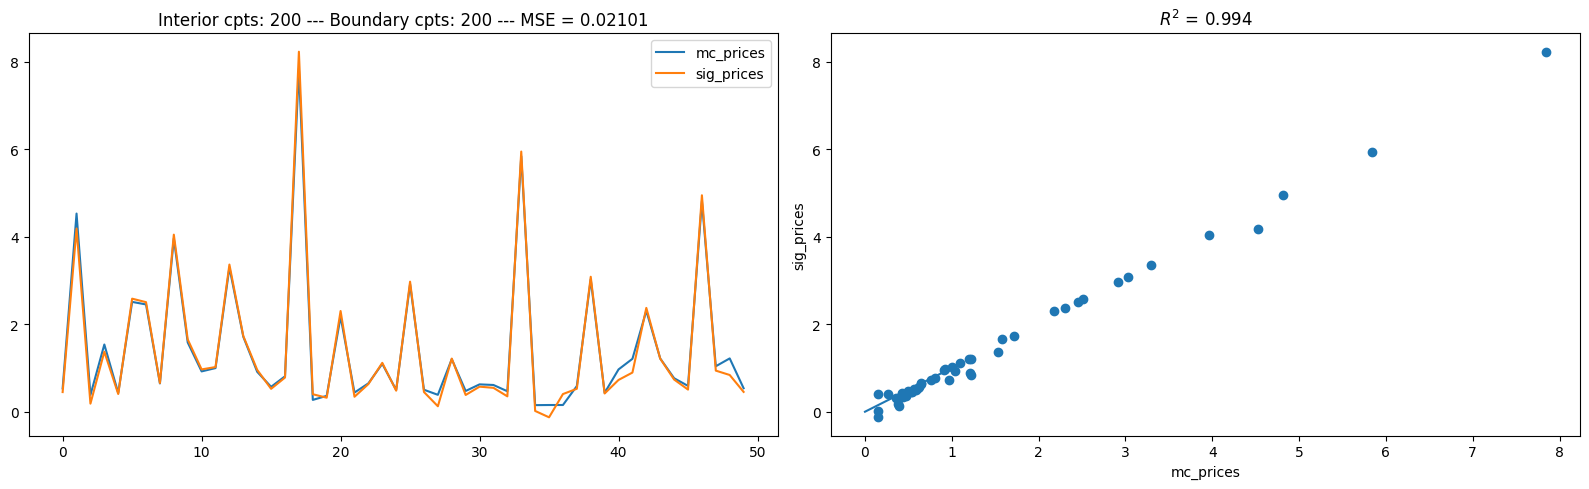

In [20]:
plot_results(mc_prices, sig_prices, m, n)

In [ ]:
# # gradient descent parameters
# phi          = lambda x: max(x - np.exp(log_strike), 0.)  
# lr           = 1e-2
# n_iter       = 100
# print_every  = 5
# batch_size   = 100
# lambda_      = 0.5
# penalty      = 1e-5
# dt_scheduler = 50
# x_scheduler  = 0.5

In [8]:
# t_ind_try, t_try, x_try, T_try, K_try = generator(m, n_increments+1, T, mid_price, a, xi, eta, rho)
# fig, ax = plt.subplots(1, 2, figsize=(10,4))
# for j in range(N):
#     ax[0].plot(T_try[j,:,0], T_try[j,:,1], color='blue', alpha=0.1)
#     ax[1].plot(K_try[j,:,1], color='red', alpha=0.1)
# ax[0].set_title('Evaluation paths')
# ax[1].set_title('Directions')
# plt.show()

In [14]:
# eval_paths = generate_evaluation_paths(t_ind_try, n_increments, T, a)
# rb_sigkernel = rBergomi_sigkernel_pricer(n_increments, mid_price, m, n, T, a, xi, eta, rho, 
#                                          sigma_t, sigma_x, sigma_sig, max_batch, device)
# rb_sigkernel.fit(payoff_eur_call)
# directions = rb_sigkernel.directions
# fig, ax = plt.subplots(1, 2, figsize=(10,4))
# for j in range(m):
#     ax[0].plot(eval_paths[j,:,0], eval_paths[j,:,1], color='blue', alpha=0.1)
#     ax[1].plot(directions[j,:,1], color='red', alpha=0.1)
# ax[0].set_title('Evaluation paths')
# ax[1].set_title('Directions')
# plt.show()

In [3]:
# def exp_kernel(x, y, sigma):
#     return torch.exp(-(x-y)**2/(2.*sigma**2))

# def K(s, t, a):
#     return (s-t)**a

# def psi(t, x, a, xi, eta):
#     return xi*torch.exp(eta*np.sqrt(2*a+1)*x-(eta**2/2)*t**(2*a-1))

# def r2(x, y):
#     return scipy.stats.pearsonr(x, y)[0] ** 2

In [41]:
# def generator(n_samples, n_steps, T, x0, a, xi, eta, rho, random_state=None):

#     """Returns: 
#                 - idx: tensor of shape (n_samples,) of randomly chosen indices in {0,1,...,n_steps-1}
#                 - ts: tensor of shape (n_samples,) of time indices in [0,T]
#                 - xs: tensor of shape (n_samples,) of prices ~ N(x0, 1)
#                 - Ts: tensor of shape (n_samples, n_steps, 2) of time-augmented paths Theta^t with t in ts
#                 - Ks: tensor of shape (n_samples, n_steps, 2) of time-augmented paths K^t with t in ts
#     """

#     # set random state
#     np.random.seed(random_state)

#     # time steps
#     dt = T/n_steps

#     # time grid
#     t_grid = torch.linspace(0., T, n_steps)
    
#     # random time indices
#     idx = np.random.choice(np.arange(n_steps), n_samples)

#     # initialize arrays
#     ts = torch.zeros((n_samples,), dtype=torch.float64)
#     xs = torch.normal(mean=x0*torch.ones(n_samples), std=1).to(dtype=torch.float64)
#     Ts = torch.zeros((n_samples, n_steps, 2), dtype=torch.float64)
#     Ks = torch.zeros((n_samples, n_steps, 2), dtype=torch.float64)

#     # Generate sample paths
#     for i in range(n_samples):
        
#         # Brownian increments
#         dw = torch.normal(0., torch.sqrt(torch.tensor(dt)), size=(n_steps-1, ))

#         # cut-off point t0
#         i0 = idx[i]
#         t0 = i0*dt

#         # time samples
#         ts[i] = t0

#         # Theta^t
#         Ts[i,:,0] = t_grid
#         for j in range(i0, n_steps): 
#             t = j*dt
#             integral = 0.
#             for k in range(i0):
#                 r = k*dt
#                 integral += ((r-t)**a)*dw[k] 
#             Ts[i,j,1] = integral
        
#         # K^t
#         for j in range(i0+1, n_steps):
#             t = j*dt
#             Ks[i, j, 1] = (t - t0)**a

#     return idx, ts, xs, Ts, Ks 

In [5]:
# def L(alphas, signature_kernel, t_cps, x_cps, T_cps, sigma_t, sigma_x, sigma_sig, batch_size, 
#       n_steps, T, x0, a, xi, eta, rho, phi, lambda_, penalty):
    
#     # nb of collocation points
#     n_cps = alphas.shape[0]
    
#     # generate samples
#     idx_batch, t_batch, x_batch, T_batch, K_batch = generator(batch_size, n_steps, T, x0, a, xi, eta, rho)
    
#     # compute first and second directional derivatives of sigkernel
#     ksig, ksig_diff, ksig_diffdiff = signature_kernel.compute_kernel_and_derivatives_Gram(T_batch.to(device), 
#                                                                                           T_cps.to(device), 
#                                                                                           K_batch.to(device))
            
#     losses = torch.zeros((batch_size,))
#     losses_T = torch.zeros((batch_size,))
#     for j in range(batch_size): 
        
#         # Sample t, x
#         ind = idx_batch[j]
#         t = t_batch[j]
#         x = x_batch[j]
#         wt = T_batch[j,ind,1]

#         loss = 0.
#         loss_T = 0.
#         for i in range(n_cps):
            
#             # select collocation points
#             ti = t_cps[i]
#             xi = x_cps[i]
                      
#             # factors appearing in loss
#             l_t = (t-ti)/(sigma_t**2) 
#             l_x = (x-xi)/(sigma_x**2) 
#             l_xx = (sigma_x**2 - (x-xi)**2)/(sigma_x**4)
#             e_t = exp_kernel(t, ti, sigma_t)
#             e_T = exp_kernel(T, ti, sigma_t)
#             e_x = exp_kernel(x, xi, sigma_x)
#             p = psi(t, wt, a, xi, eta)

#             # terms in loss
#             u_T  = e_T*e_x*ksig[j,i]
#             D_t  = -l_t*e_t*e_x*ksig[j,i]
#             D_x  = -l_x*e_t*e_x*ksig[j,i]
#             D_xx = -l_xx*e_t*e_x*ksig[j,i]
#             D_Kx = -l_x*e_t*e_x*ksig_diff[j,i]
#             D_KK = e_t*e_x*ksig_diffdiff[j,i]

#             # putting everything together
#             loss += alphas[i]*(D_t -0.5*(p**2)*D_x + 0.5*(p**2)*D_xx + 0.5*D_KK + rho*p*D_Kx)
#             loss_T += alphas[i]*u_T

#         losses[j] = loss**2
#         losses_T[j] = (loss_T - phi(x))**2

#     return lambda_*torch.mean(losses) + (1.-lambda_)*torch.mean(losses_T) + penalty*torch.sum(alphas**2)


# def evaluate(alphas, signature_kernel, t_cps, x_cps, T_cps, sigma_t, sigma_x, sigma_sig, t_batch, x_batch, T_batch):
#     n_cps = alphas.shape[0]
#     batch_size = t_batch.shape[0]
#     out = torch.zeros((batch_size,))
#     for j in range(batch_size):
#         for i in range(n_cps):
#             e_t = exp_kernel(t_batch[j], t_cps[i], sigma_t)
#             e_x = exp_kernel(x_batch[j], x_cps[i], sigma_x)
#             ksig = signature_kernel.compute_kernel(T_batch[j].unsqueeze(0).to(device), T_cps[i].unsqueeze(0).to(device))[0]
#             out[j] = out[j] + alphas[i]*e_t*e_x*ksig
#     return out

In [26]:
# # collocation points
# _, t_cps, x_cps, T_cps, _ = generator(m+n, n_increments+1, T, mid_price, a, xi, eta, rho)

# # Specify the static kernel 
# static_kernel = sigkernel.RBFKernel(sigma=sigma_sig)

# # Initialize the corresponding signature kernel
# signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order=1)

# # randomly initialize the trainable parameters
# alphas = torch.tensor(np.random.normal(size=m+n, scale=np.sqrt(1./m+n)), requires_grad=True)
# # alphas = torch.zeros((n_cps,), requires_grad=True)

# # for evaluation
# t_batch_eval = torch.tensor(n_eval*[0.], dtype=torch.float64)
# x_batch_eval = torch.tensor(xs_eval, dtype=torch.float64)
# T_batch_eval = torch.zeros((n_eval, n_increments+1, 2), dtype=torch.float64)
# T_batch_eval[:,:,0] = torch.linspace(0, 1, n_increments+1).to(dtype=torch.float64)

# # optimiser
# optimizer = torch.optim.Adam([alphas], lr=lr)

# # scheduler
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=dt_scheduler, gamma=x_scheduler)

# # store losses
# losses = []

In [42]:
# # training by gradient descent
# for i in range(n_iter):
    
#     optimizer.zero_grad()
    
#     # computing loss
#     loss = L(alphas, signature_kernel, t_cps, x_cps, T_cps, sigma_t, sigma_x, sigma_sig, 
#              batch_size, n_increments+1, T, mid_price, a, xi, eta, rho, phi, lambda_, penalty) 
    
#     # storing the calculated loss
#     losses.append(loss.item())
    
#     # backward pass for computing the gradients of the loss w.r.t to learnable parameters
#     loss.backward()
    
#     # run optimiser
#     optimizer.step()
    
#     # run scheduler to decrease learning rate
#     scheduler.step()
        
#     # evaluation
#     if i % print_every == 0:
#         with torch.no_grad():
#             sigkernel_prices_old = evaluate(alphas, signature_kernel, t_cps, x_cps, T_cps, sigma_t, sigma_x, sigma_sig, t_batch_eval, x_batch_eval, T_batch_eval)

#             # priting the values for understanding
#             print('iter: {}, call price: {:.2f}, loss: {:.3f}, learning rate: {:.6f} '.format(i, sigkernel_prices_old.mean().item(), loss.item(), scheduler.get_last_lr()[0]))

In [43]:
# plt.plot(losses)
# plt.show()